<a href="https://colab.research.google.com/github/eTeReBeReTe/Stock-Price-Prediction-using-LSTM-and-Technical-Indicators/blob/main/Price%20Prediction%20using%20LSTM%20and%20TA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import math
import yfinance as yf

In [95]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
from keras.layers import Dense

In [54]:
START = "2000-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

# Define a function to load the dataset

def load_data(ticker):
    stock = yf.Ticker(ticker)
    data = stock.history(start=START, end=TODAY, auto_adjust = False)
    #data = yf.download(ticker, START, TODAY)
    data['Company Name'] = stock.info['longName']
    data.reset_index(inplace=True)
    data['Date'] = data['Date'].dt.tz_localize(None)  # drop the timezone
    #data['Date'] = data['Date'].dt.date                # cast to plain date
    # **make Date the index**
    data.set_index('Date', inplace=True)
    return data

In [55]:
df = load_data('NVDA')
data=df.drop(columns=["Dividends", "Stock Splits"])
data.head()

,Open,High,Low,Close,Adj Close,Volume,Company Name
Date,,,,,,,
2010-01-04,0.46275,0.4655,0.45275,0.46225,0.423884,800204000,NVIDIA Corporation
2010-01-05,0.46050,0.4740,0.46050,0.46900,0.430073,728648000,NVIDIA Corporation
2010-01-06,0.46875,0.4730,0.46425,0.47200,0.432824,649168000,NVIDIA Corporation
2010-01-07,0.46950,0.4715,0.45925,0.46275,0.424342,547792000,NVIDIA Corporation
2010-01-08,0.45900,0.4670,0.45625,0.46375,0.425259,478168000,NVIDIA Corporation


In [56]:
data = data[['Adj Close']]
data.columns = ['Price']
data.head()

,Price
Date,
2010-01-04,0.423884
2010-01-05,0.430073
2010-01-06,0.432824
2010-01-07,0.424342
2010-01-08,0.425259


In [57]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 3875 number of days in the dataset.


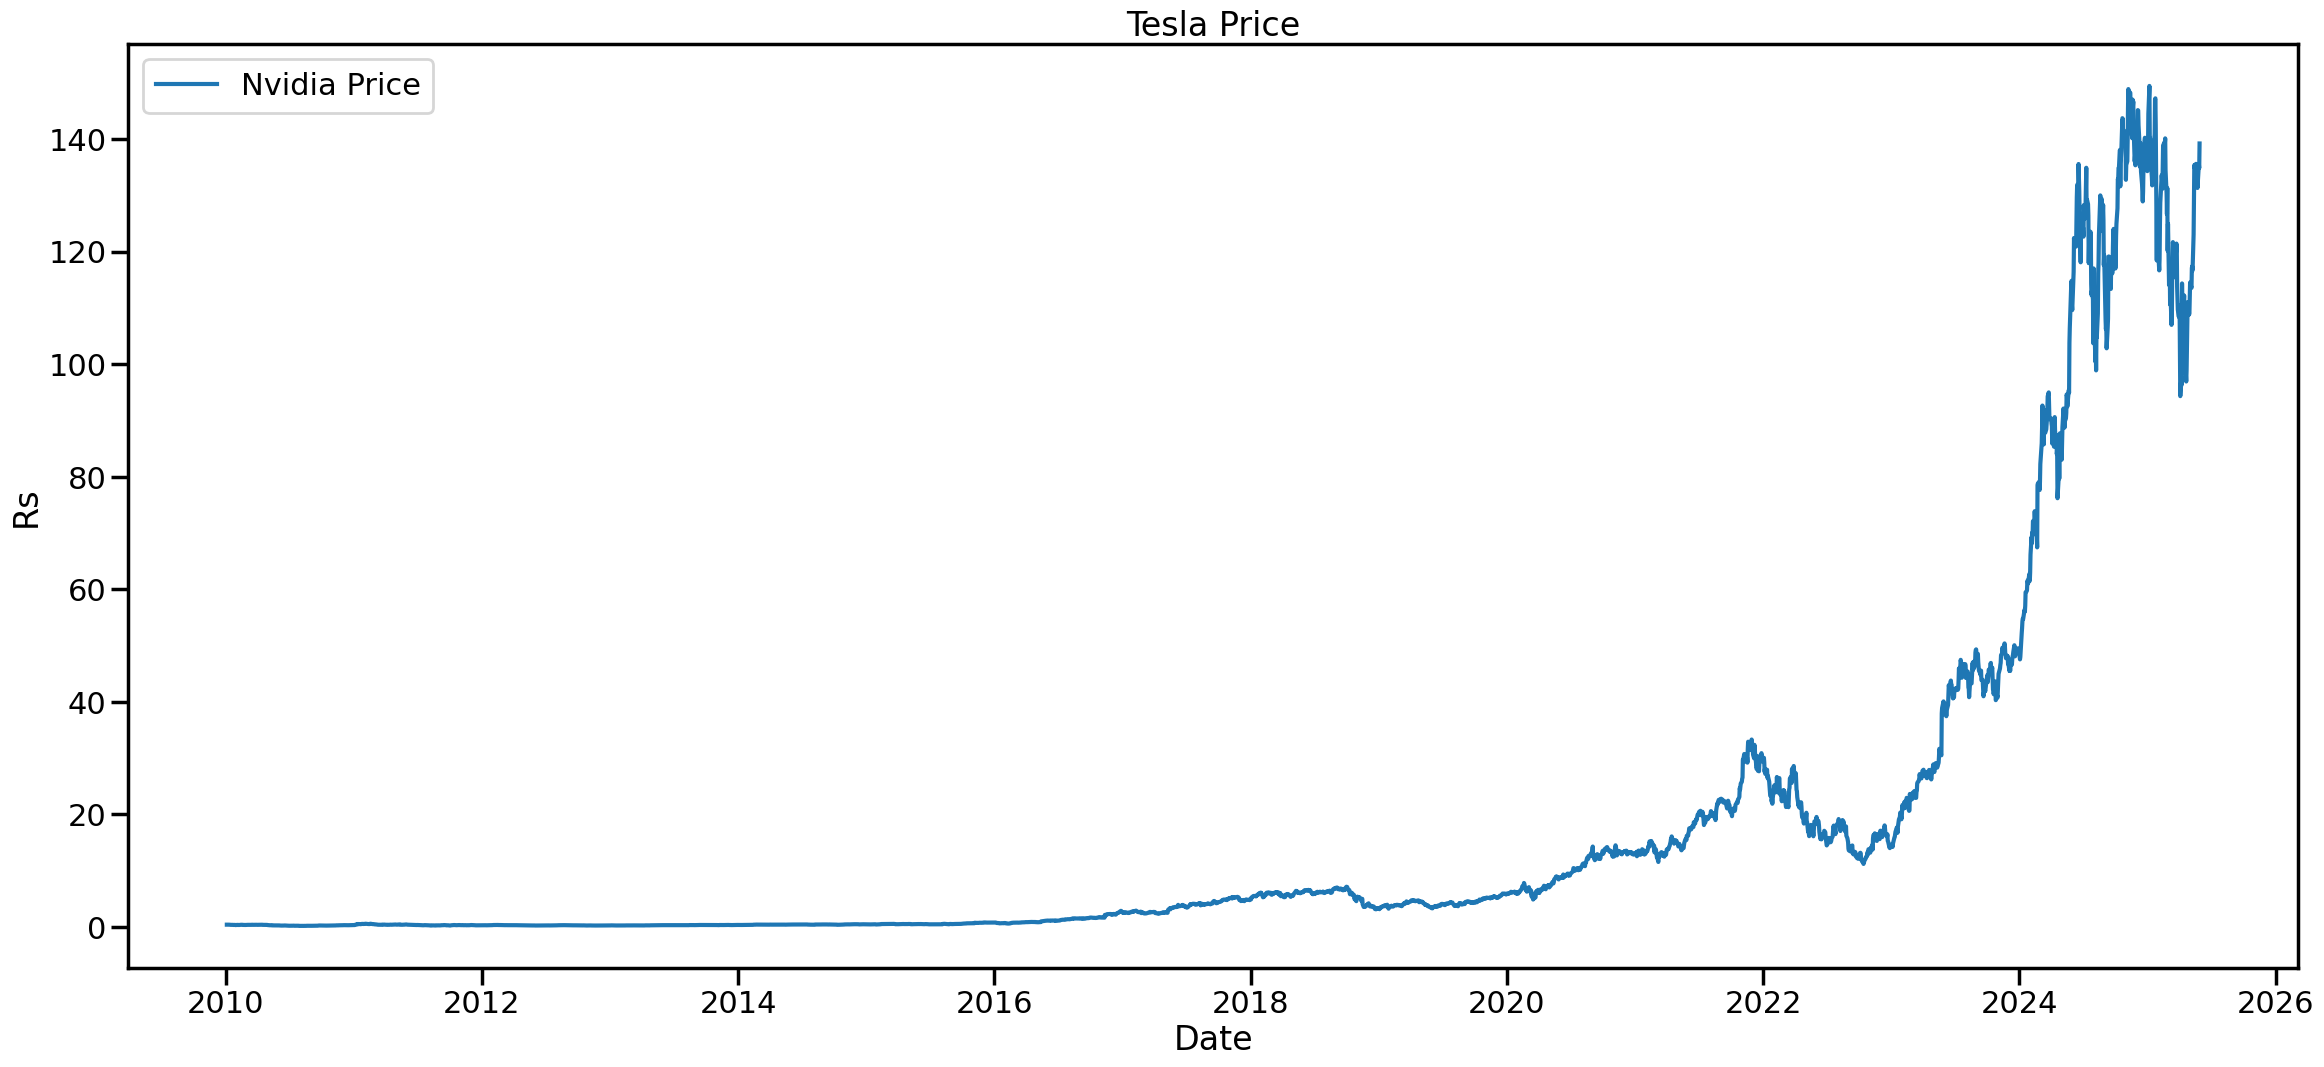

In [58]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(data.index, data['Price'], label='Nvidia Price')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Nvidia Price')
plt.legend()
plt.show()

In [59]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Price'].rolling(window=21).mean()

    # Create MACD
    dataset['26ema'] = dataset['Price'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Price'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Price'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Price'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset['Price']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [60]:
df = get_technical_indicators(data)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [61]:
df = df.dropna()
df.head()

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2016-05-13,1.003432,0.889013,0.888476,0.881493,0.894487,0.012994,0.031069,0.950615,0.826338,0.960307,0.003432,-5.674498
2016-05-16,1.033060,0.914268,0.894376,0.892720,0.915806,0.023086,0.044188,0.982752,0.806001,1.008809,0.033060,-3.409440
2016-05-17,1.035263,0.938579,0.900568,0.903279,0.934184,0.030905,0.053841,1.008250,0.792885,1.026445,0.035263,-3.344909
2016-05-18,1.061708,0.966843,0.908788,0.915015,0.953803,0.038788,0.064184,1.037157,0.780419,1.049954,0.061708,-2.785340
2016-05-19,1.066361,0.993393,0.917067,0.926225,0.971120,0.044894,0.072635,1.062337,0.771796,1.060892,0.066361,-2.712652


In [62]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(30,20))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Tesla - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot

    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

<Figure size 1600x1000 with 0 Axes>

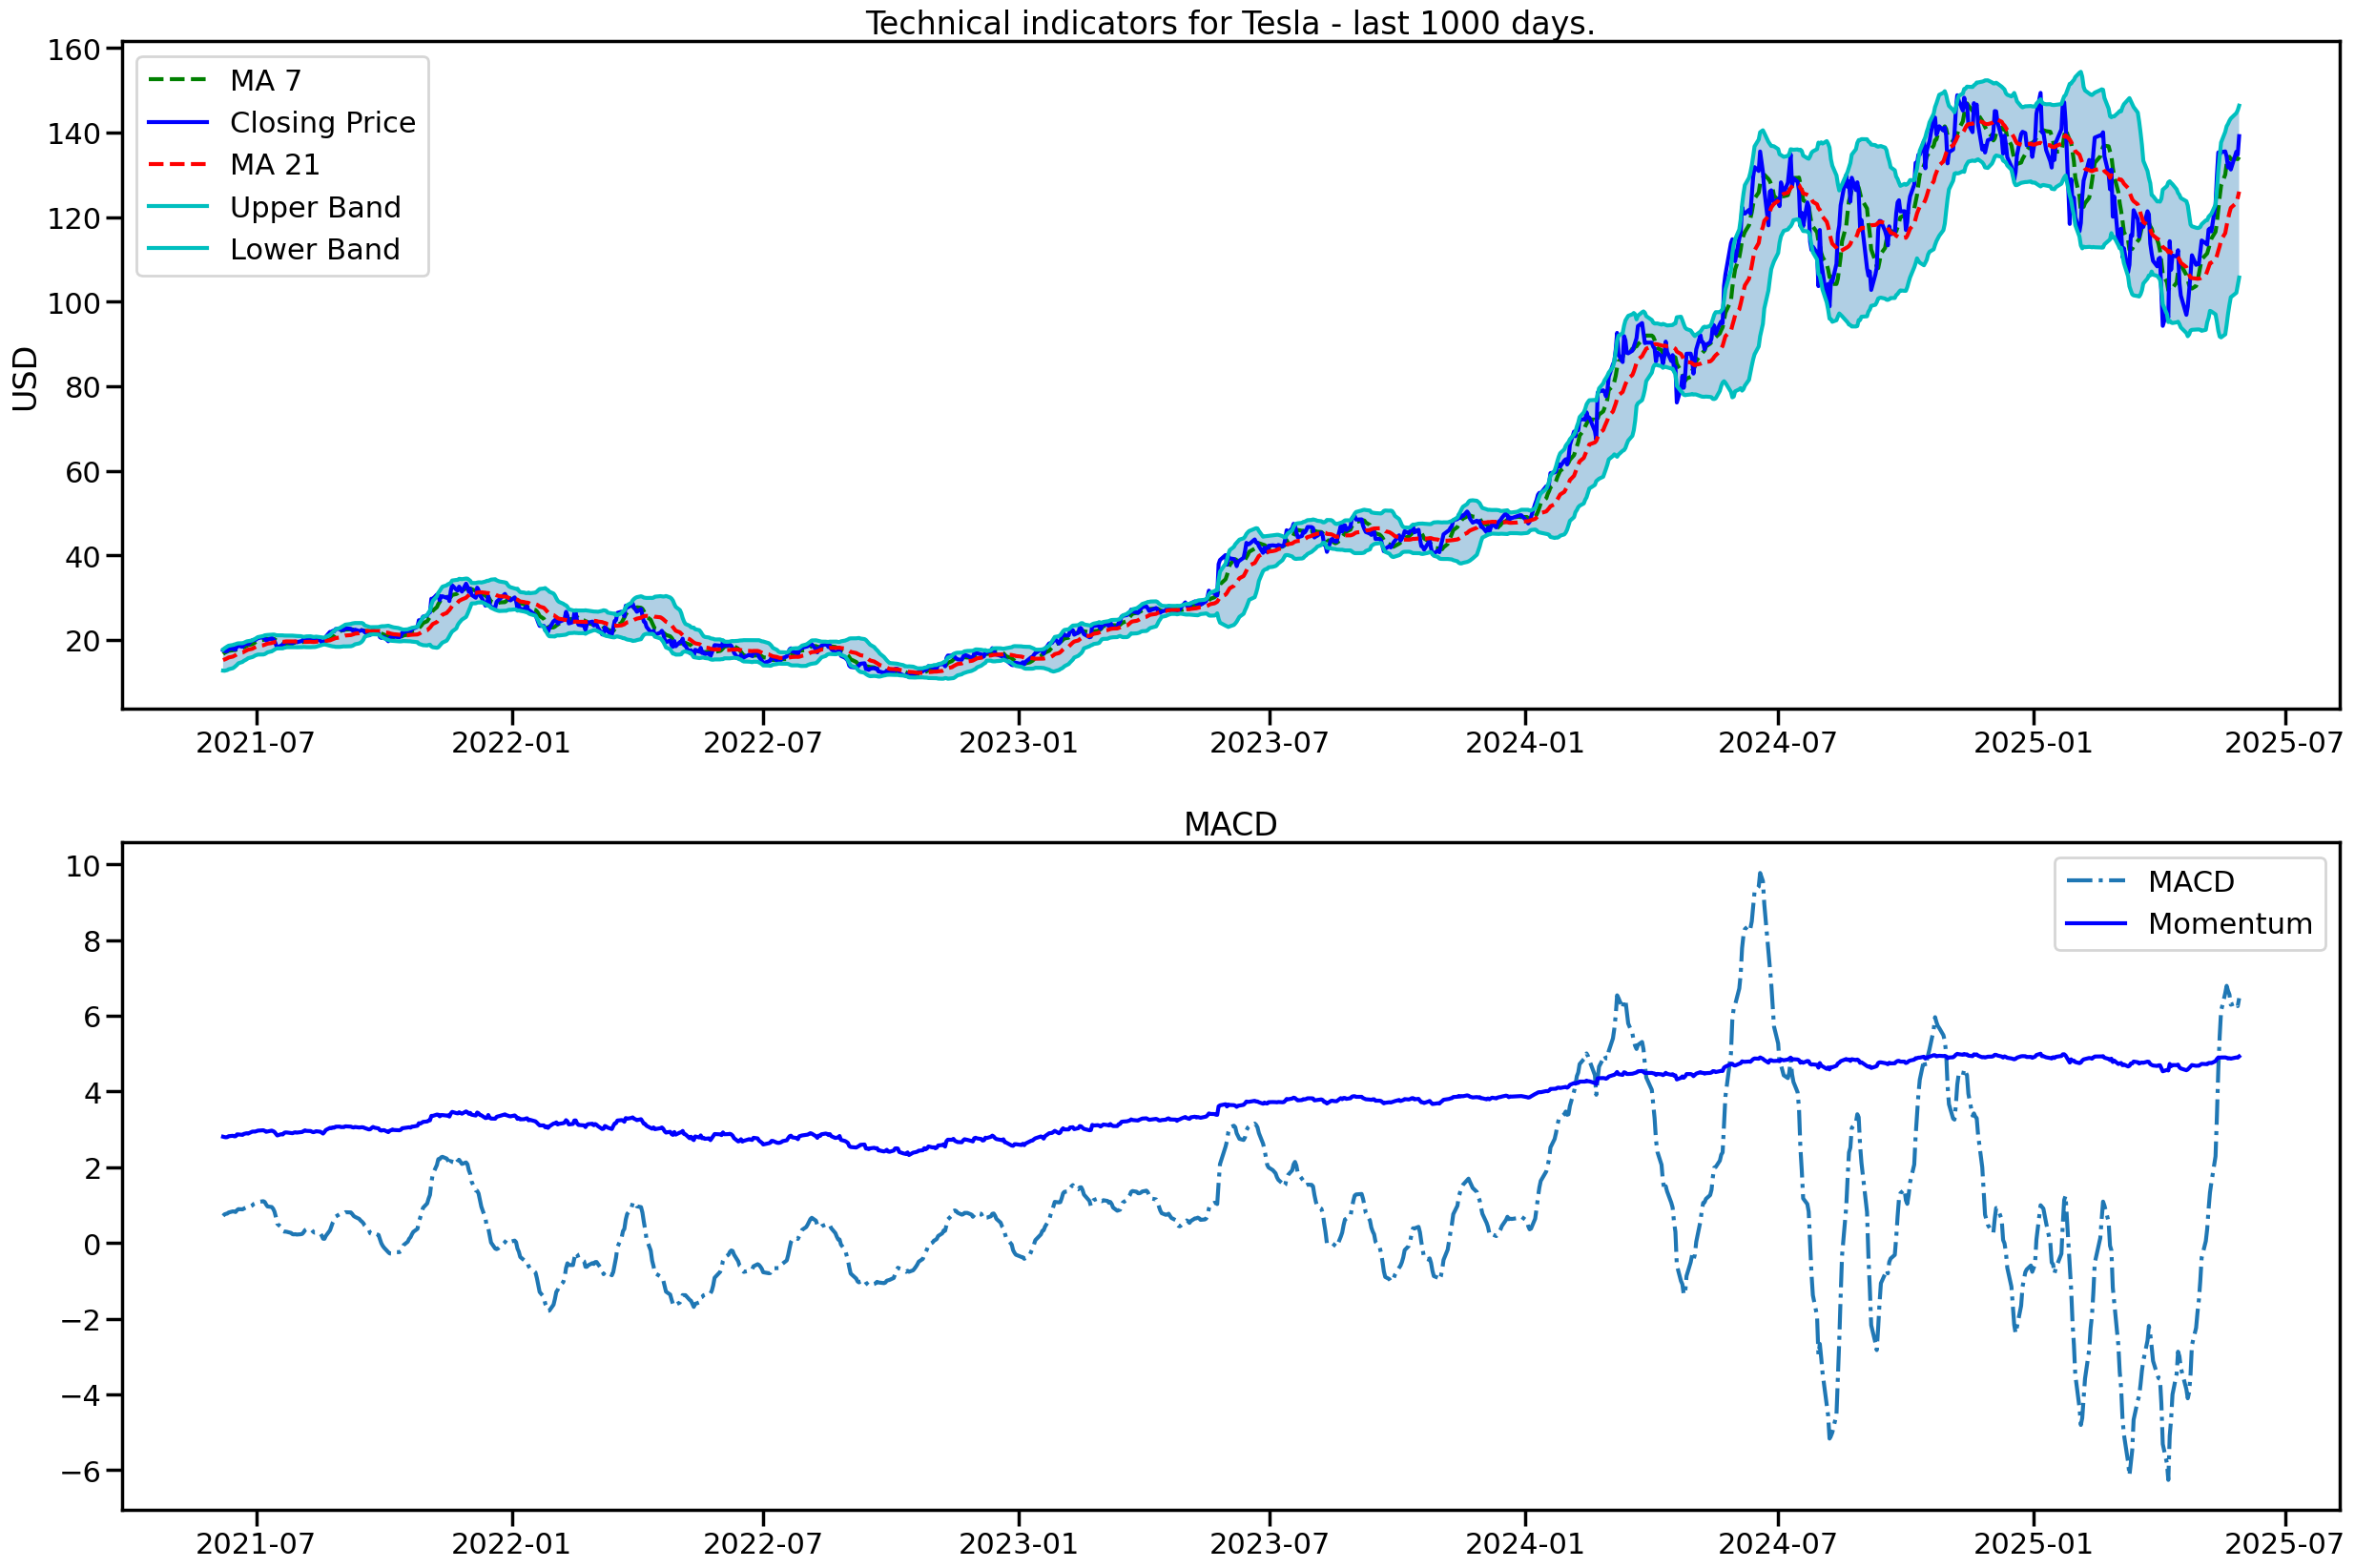

In [63]:
plot_technical_indicators(df, 1000)

Text(0.5, 1.0, 'Params')

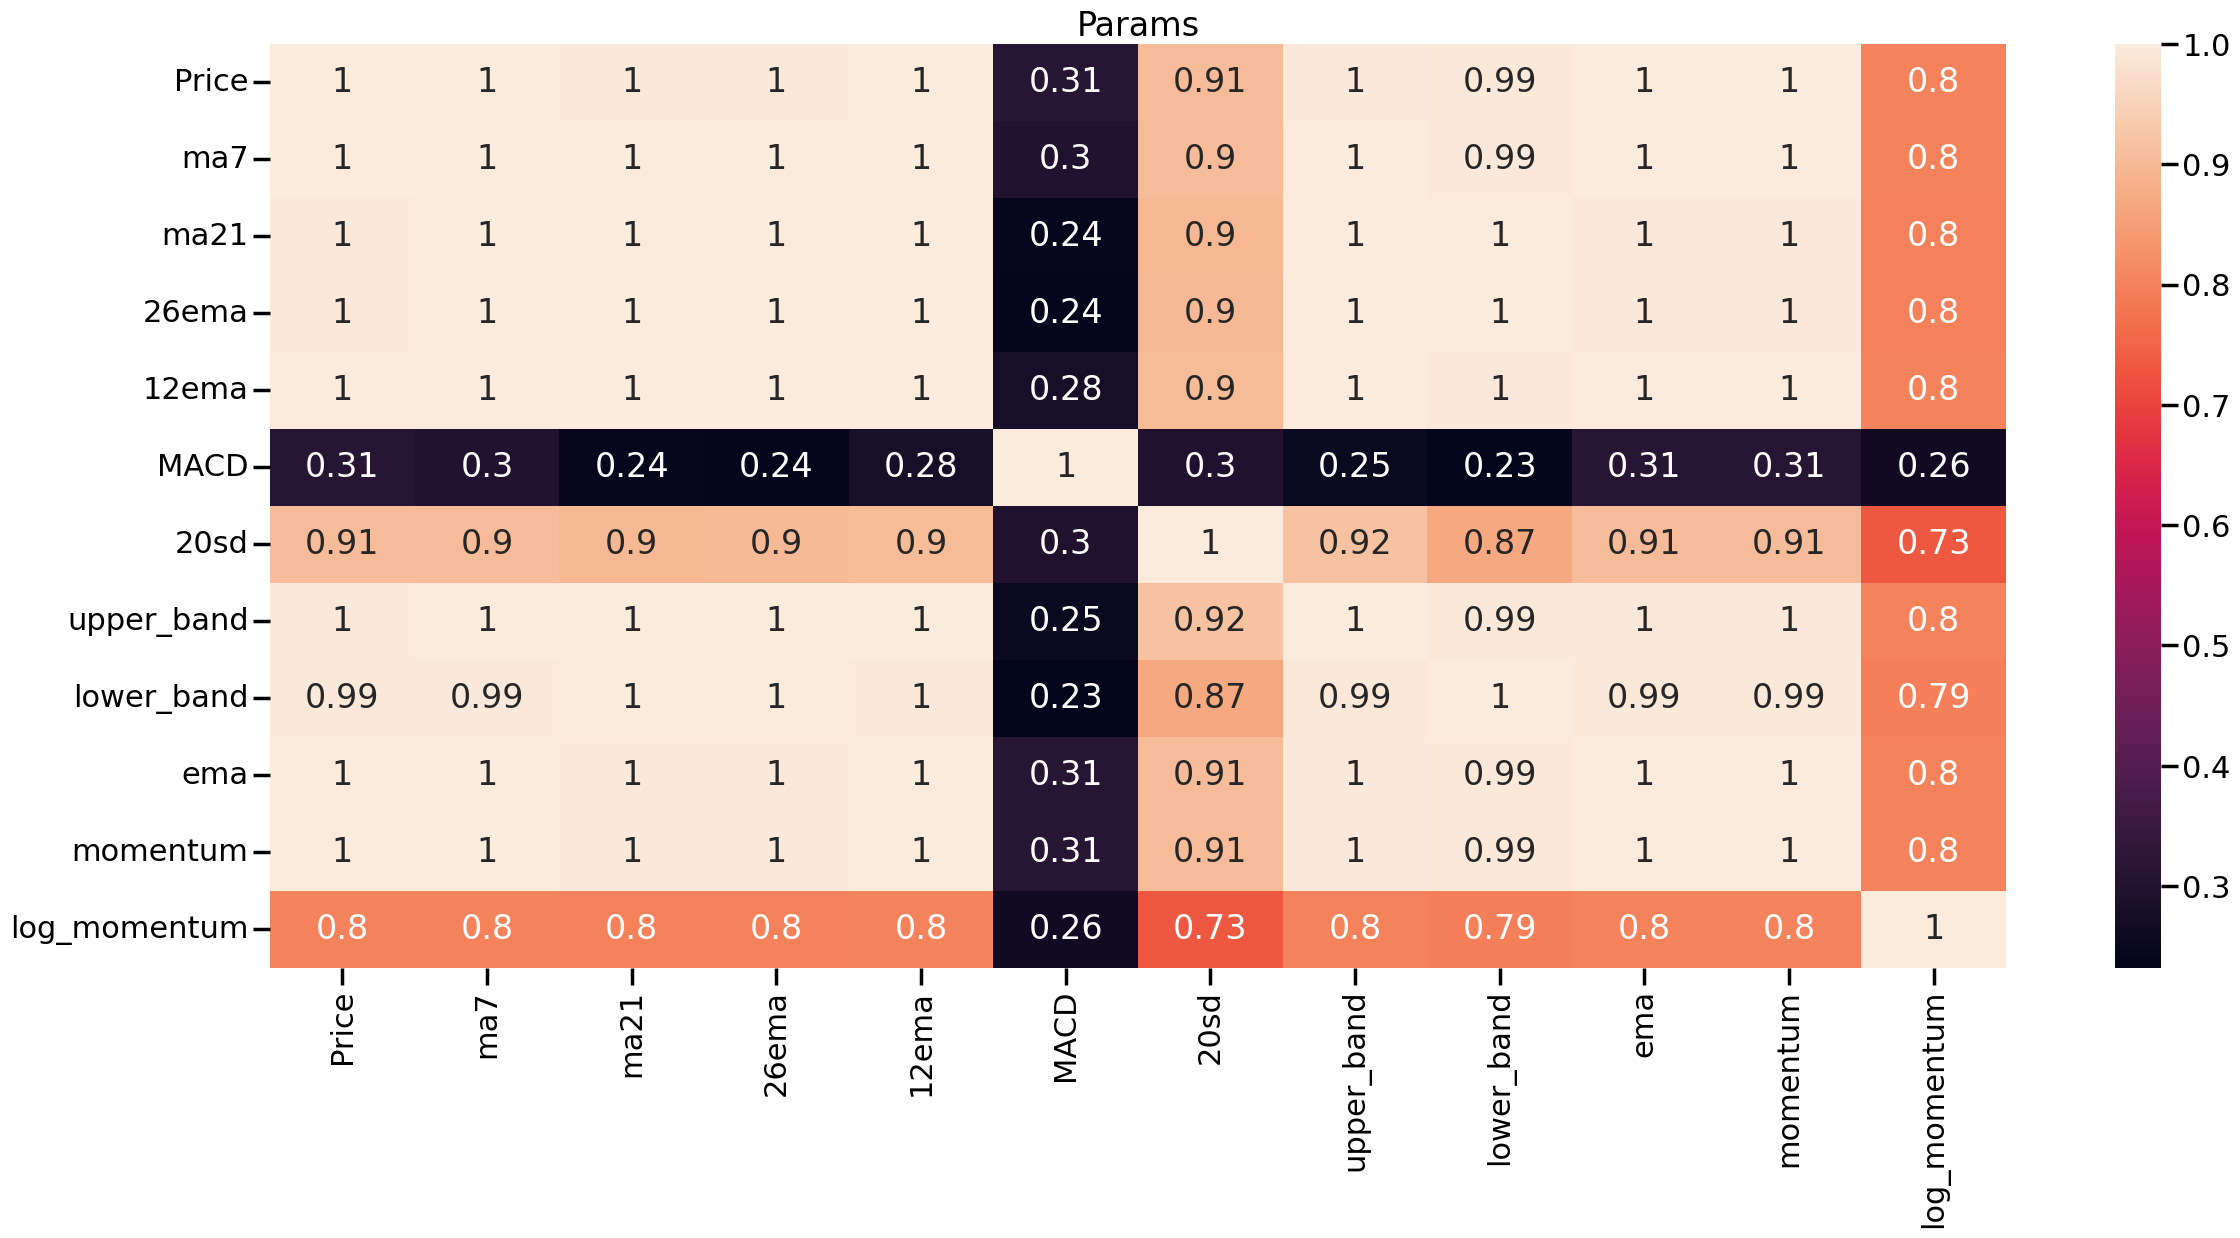

In [64]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(df.corr(), annot = True).set_title('Params')


In [65]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 2274 samples, and 12 features.


In [66]:
df.columns

Index(['Price', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band',
       'lower_band', 'ema', 'momentum', 'log_momentum'],
      dtype='object')

In [67]:
df

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2016-05-13,1.003432,0.889013,0.888476,0.881493,0.894487,0.012994,0.031069,0.950615,0.826338,0.960307,0.003432,-5.674498
2016-05-16,1.033060,0.914268,0.894376,0.892720,0.915806,0.023086,0.044188,0.982752,0.806001,1.008809,0.033060,-3.409440
2016-05-17,1.035263,0.938579,0.900568,0.903279,0.934184,0.030905,0.053841,1.008250,0.792885,1.026445,0.035263,-3.344909
2016-05-18,1.061708,0.966843,0.908788,0.915015,0.953803,0.038788,0.064184,1.037157,0.780419,1.049954,0.061708,-2.785340
2016-05-19,1.066361,0.993393,0.917067,0.926225,0.971120,0.044894,0.072635,1.062337,0.771796,1.060892,0.066361,-2.712652
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-22,132.830002,134.307144,121.035238,122.045071,128.612140,6.567069,10.893152,142.821543,99.248934,132.809816,131.830002,4.881513
2025-05-23,131.289993,133.728572,122.219048,122.729880,129.024117,6.294237,10.572684,143.364415,101.073680,131.796601,130.289993,4.869763
2025-05-27,135.500000,133.824286,123.385238,123.675815,130.020407,6.344592,10.625003,144.635245,102.135231,134.265534,134.500000,4.901564


**Spliting the dataset into training (70%) and testing (30%) set**

In [68]:
# Splitting data into training and testing
train = pd.DataFrame(df[0:int(len(df)*0.70)])
test = pd.DataFrame(df[int(len(df)*0.70): int(len(df))])

print(train.shape)
print(test.shape)

(1591, 12)
(683, 12)


In [69]:
#data_training = df[df.index < '2019-01-31'].copy()
data_training = train.copy()
data_training

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2016-05-13,1.003432,0.889013,0.888476,0.881493,0.894487,0.012994,0.031069,0.950615,0.826338,0.960307,0.003432,-5.674498
2016-05-16,1.033060,0.914268,0.894376,0.892720,0.915806,0.023086,0.044188,0.982752,0.806001,1.008809,0.033060,-3.409440
2016-05-17,1.035263,0.938579,0.900568,0.903279,0.934184,0.030905,0.053841,1.008250,0.792885,1.026445,0.035263,-3.344909
2016-05-18,1.061708,0.966843,0.908788,0.915015,0.953803,0.038788,0.064184,1.037157,0.780419,1.049954,0.061708,-2.785340
2016-05-19,1.066361,0.993393,0.917067,0.926225,0.971120,0.044894,0.072635,1.062337,0.771796,1.060892,0.066361,-2.712652
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,15.073307,16.397346,17.669313,17.176010,16.725390,-0.450621,1.226723,20.122758,15.215868,15.269312,14.073307,2.644280
2022-09-01,13.917892,15.934553,17.433637,16.934668,16.293467,-0.641201,1.441684,20.317005,14.550269,14.368365,12.917892,2.558613
2022-09-02,13.628288,15.424538,17.168857,16.689751,15.883439,-0.806312,1.604639,20.378136,13.959579,13.874980,12.628288,2.535939


In [70]:
#data_testing = df[df.index >= '2019-01-31'].copy()
data_testing = test.copy()
data_testing

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2022-09-08,13.974970,14.169579,16.565364,16.077582,15.037073,-1.040509,1.953892,20.473147,12.657580,13.870856,12.974970,2.563022
2022-09-09,14.371544,14.015972,16.389142,15.951209,14.934684,-1.016525,1.977929,20.345000,12.433285,14.204648,13.371544,2.593129
2022-09-12,14.489419,13.932560,16.225905,15.842928,14.866182,-0.976746,1.986931,20.199766,12.252044,14.394495,13.489419,2.601906
2022-09-13,13.116893,13.818131,15.960836,15.641000,14.597060,-1.043939,2.013818,19.988473,11.933199,13.542760,12.116893,2.494601
2022-09-14,13.113895,13.744647,15.680264,15.453807,14.368881,-1.084926,1.978494,19.637253,11.723276,13.256850,12.113895,2.494353
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-22,132.830002,134.307144,121.035238,122.045071,128.612140,6.567069,10.893152,142.821543,99.248934,132.809816,131.830002,4.881513
2025-05-23,131.289993,133.728572,122.219048,122.729880,129.024117,6.294237,10.572684,143.364415,101.073680,131.796601,130.289993,4.869763
2025-05-27,135.500000,133.824286,123.385238,123.675815,130.020407,6.344592,10.625003,144.635245,102.135231,134.265534,134.500000,4.901564


In [71]:
scalar = MinMaxScaler()

data_training_scaled = scalar.fit_transform(data_training)
print(data_training_scaled.shape)
data_training_scaled

(1591, 12)


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.16970524e-04, 8.02606397e-04, 1.94128027e-04, ...,
        1.52379747e-03, 9.16970524e-04, 2.47547821e-01],
       [9.85175492e-04, 1.57519799e-03, 3.97847622e-04, ...,
        2.07788624e-03, 9.85175492e-04, 2.54600364e-01],
       ...,
       [3.90741366e-01, 4.61932203e-01, 5.35680730e-01, ...,
        4.05744288e-01, 3.90741366e-01, 8.97317402e-01],
       [3.85116194e-01, 4.41766255e-01, 5.27037419e-01, ...,
        3.96770635e-01, 3.85116194e-01, 8.95733048e-01],
       [3.92938151e-01, 4.30241904e-01, 5.20661458e-01, ...,
        3.99072762e-01, 3.92938151e-01, 8.97929953e-01]])

In [72]:
X_train = []
y_train = []

In [73]:
for i in range(60, data_training.shape[0]):
    X_train.append(data_training_scaled[i-60: i])
    y_train.append(data_training_scaled[i, 0])

In [74]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((1531, 60, 12), (1531,))

In [97]:
regressor = Sequential()

regressor.add(Input(shape=(X_train.shape[1], 12)))

regressor.add(LSTM(units=50, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

In [76]:
regressor.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 60, 60)         │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 80)         │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,961 (706.88 KB)

 Trainable params: 180,961 (706.88 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [78]:
regressor.fit(X_train, y_train, epochs=50, batch_size = 64)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 303ms/step - loss: 0.0608
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step - loss: 0.0089
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - loss: 0.0065
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - loss: 0.0055
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step - loss: 0.0056
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 245ms/step - loss: 0.0053
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - loss: 0.0054
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 291ms/step - loss: 0.0041
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 305ms/step - loss: 0.0041
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - loss: 0.0049
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - loss: 0.0043
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - loss: 0.0045
Epoch 13/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - loss: 0.0042
Epoch 14/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - loss: 0.0042
Epoch 15/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/

In [99]:
regressor.save('keras_model.keras')

In [101]:
past_60 = data_training.tail(60)
dt = pd.concat([past_60, data_testing], ignore_index=True)
dt

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
0,15.625547,17.937812,17.730935,18.224197,17.740481,-0.483716,1.034455,19.799845,15.662025,16.211566,14.625547,2.682770
1,15.814289,17.526942,17.642187,18.045685,17.444144,-0.601542,1.115959,19.874104,15.410270,15.946715,14.814289,2.695592
2,16.504341,17.205237,17.607314,17.931512,17.299559,-0.631953,1.140438,19.888190,15.326437,16.318466,15.504341,2.741120
3,15.579609,16.731458,17.484998,17.757297,17.034951,-0.722346,1.214841,19.914681,15.055315,15.825894,14.579609,2.679624
4,15.858228,16.336571,17.434856,17.616625,16.853917,-0.762708,1.260578,19.956012,14.913700,15.847450,14.858228,2.698554
...,...,...,...,...,...,...,...,...,...,...,...,...
738,132.830002,134.307144,121.035238,122.045071,128.612140,6.567069,10.893152,142.821543,99.248934,132.809816,131.830002,4.881513
739,131.289993,133.728572,122.219048,122.729880,129.024117,6.294237,10.572684,143.364415,101.073680,131.796601,130.289993,4.869763
740,135.500000,133.824286,123.385238,123.675815,130.020407,6.344592,10.625003,144.635245,102.135231,134.265534,134.500000,4.901564
741,134.809998,133.740001,124.627142,124.500569,130.757267,6.256698,10.346918,145.320979,103.933306,134.628510,133.809998,4.896421


In [81]:
inputs = scalar.fit_transform(dt)
print(inputs.shape)
inputs

(743, 12)


array([[0.03191437, 0.04631752, 0.04208435, ..., 0.0352458 , 0.03191437,
        0.13411649],
       [0.03328007, 0.0432799 , 0.04140687, ..., 0.03329953, 0.03328007,
        0.13890781],
       [0.03827316, 0.04090149, 0.04114065, ..., 0.03603136, 0.03827316,
        0.15592013],
       ...,
       [0.89930454, 0.90308183, 0.84863009, ..., 0.90277204, 0.89930454,
        0.96320988],
       [0.8943118 , 0.9024587 , 0.85811056, ..., 0.90543939, 0.8943118 ,
        0.96128798],
       [0.92600474, 0.906282  , 0.86907781, ..., 0.92778631, 0.92600474,
        0.97332336]])

In [82]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((683, 60, 12), (683,))

In [83]:
y_pred = regressor.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


In [84]:
y_pred

array([[0.09374094],
       [0.09346658],
       [0.09312986],
       [0.09273887],
       [0.09230161],
       [0.09182609],
       [0.09131883],
       [0.09078506],
       [0.09022944],
       [0.08965881],
       [0.08907805],
       [0.08849144],
       [0.08790222],
       [0.08731204],
       [0.08672209],
       [0.08613315],
       [0.08554507],
       [0.08495866],
       [0.08437431],
       [0.0837938 ],
       [0.08322015],
       [0.0826562 ],
       [0.08210392],
       [0.08156594],
       [0.08104469],
       [0.08054236],
       [0.08006066],
       [0.07960095],
       [0.0791641 ],
       [0.07875083],
       [0.07836159],
       [0.07799651],
       [0.07765564],
       [0.07733949],
       [0.07704913],
       [0.07678459],
       [0.07654755],
       [0.07634054],
       [0.07616583],
       [0.07602268],
       [0.07590999],
       [0.07582664],
       [0.07577143],
       [0.07574385],
       [0.07574397],
       [0.07577162],
       [0.07582753],
       [0.075

In [85]:
scale = 1/scalar.scale_[0]

In [86]:
y_pred = y_pred*scale
y_test = y_test*scale

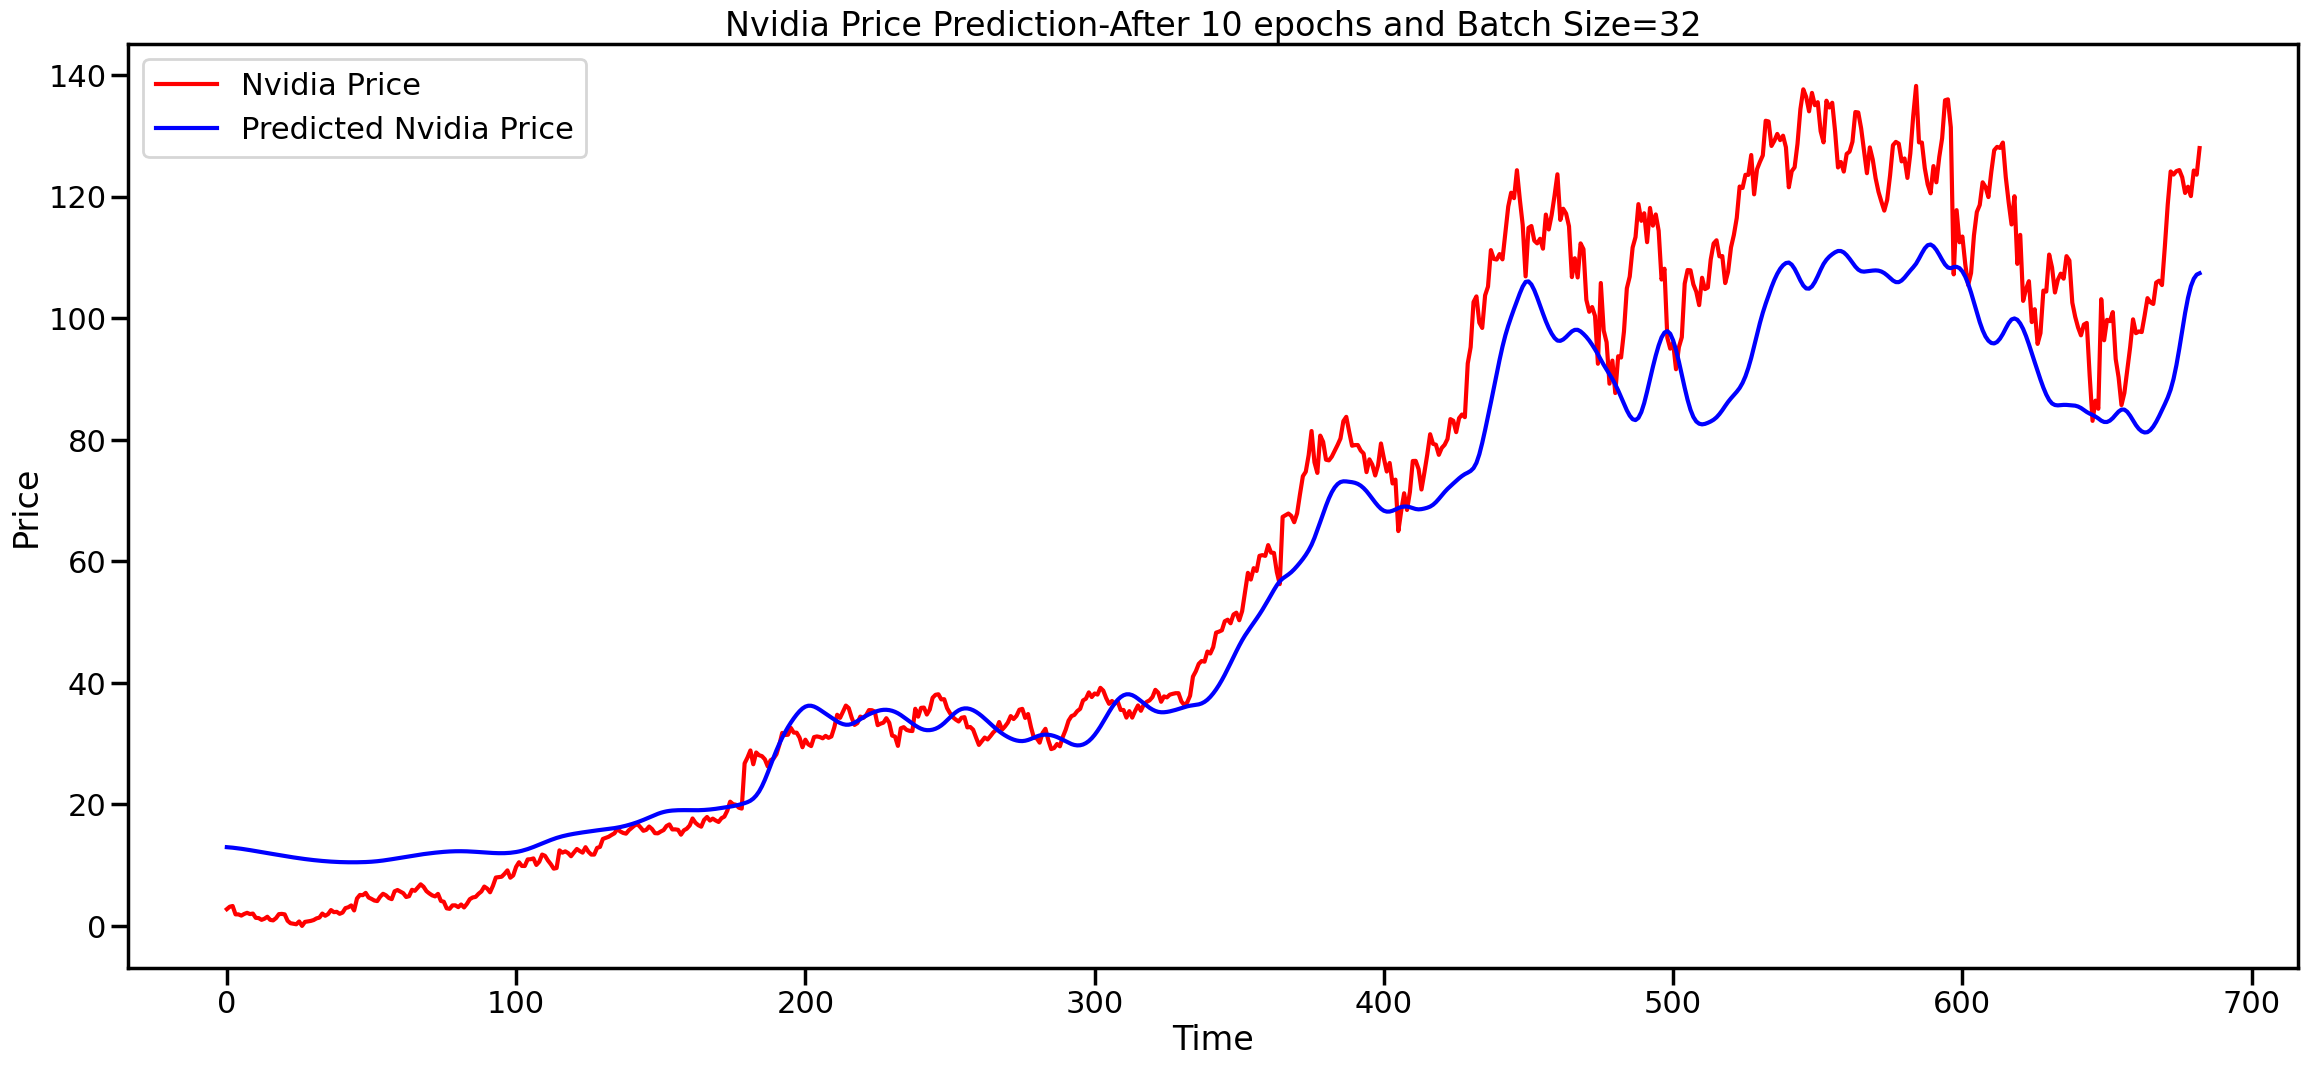

In [87]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Nvidia Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Nvidia Price')
plt.title('Nvidia Price Prediction-After 10 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

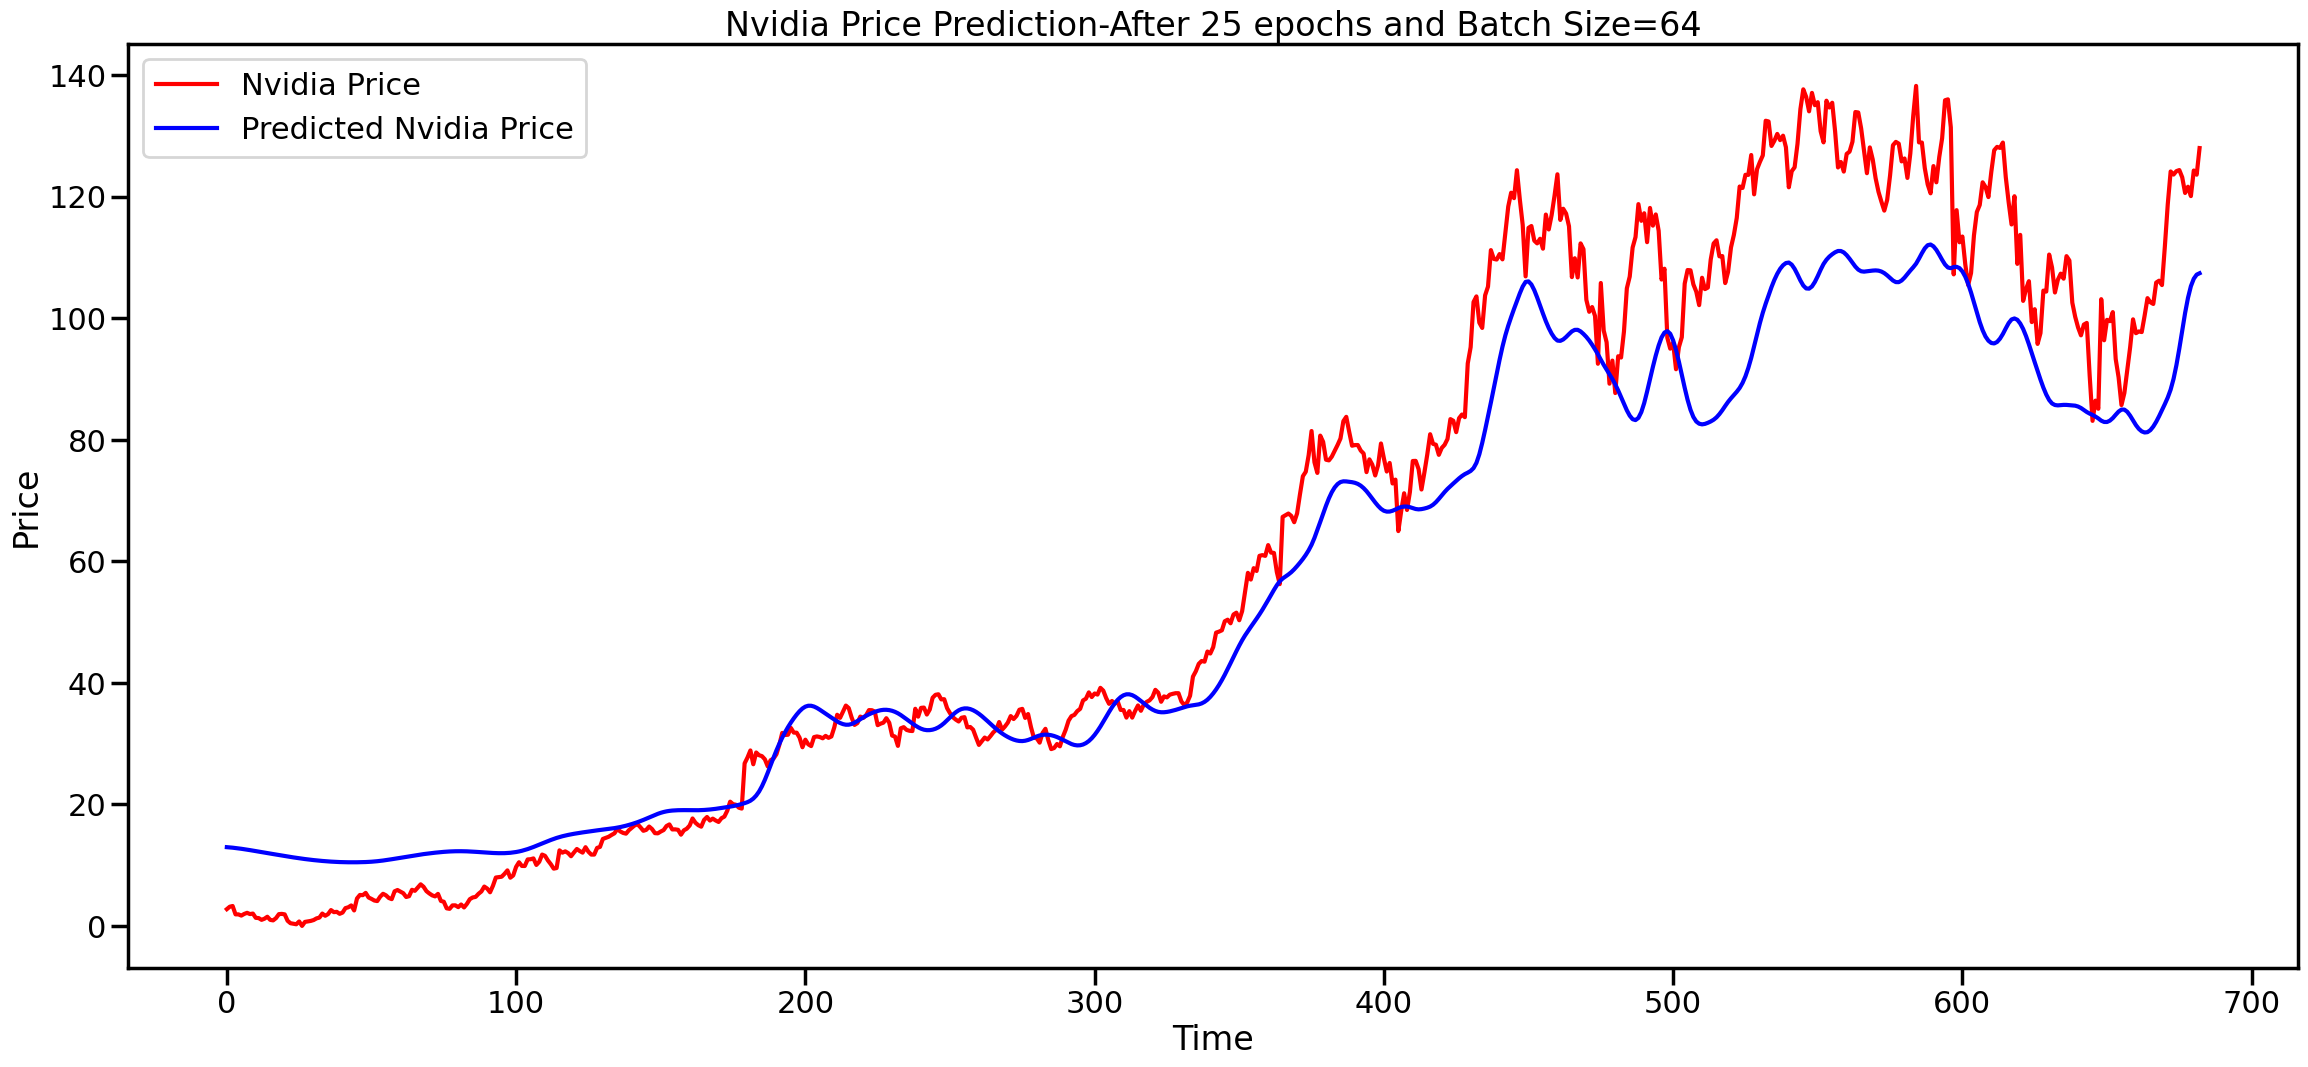

In [88]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Nvidia Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Nvidia Price')
plt.title('Nvidia Price Prediction-After 25 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

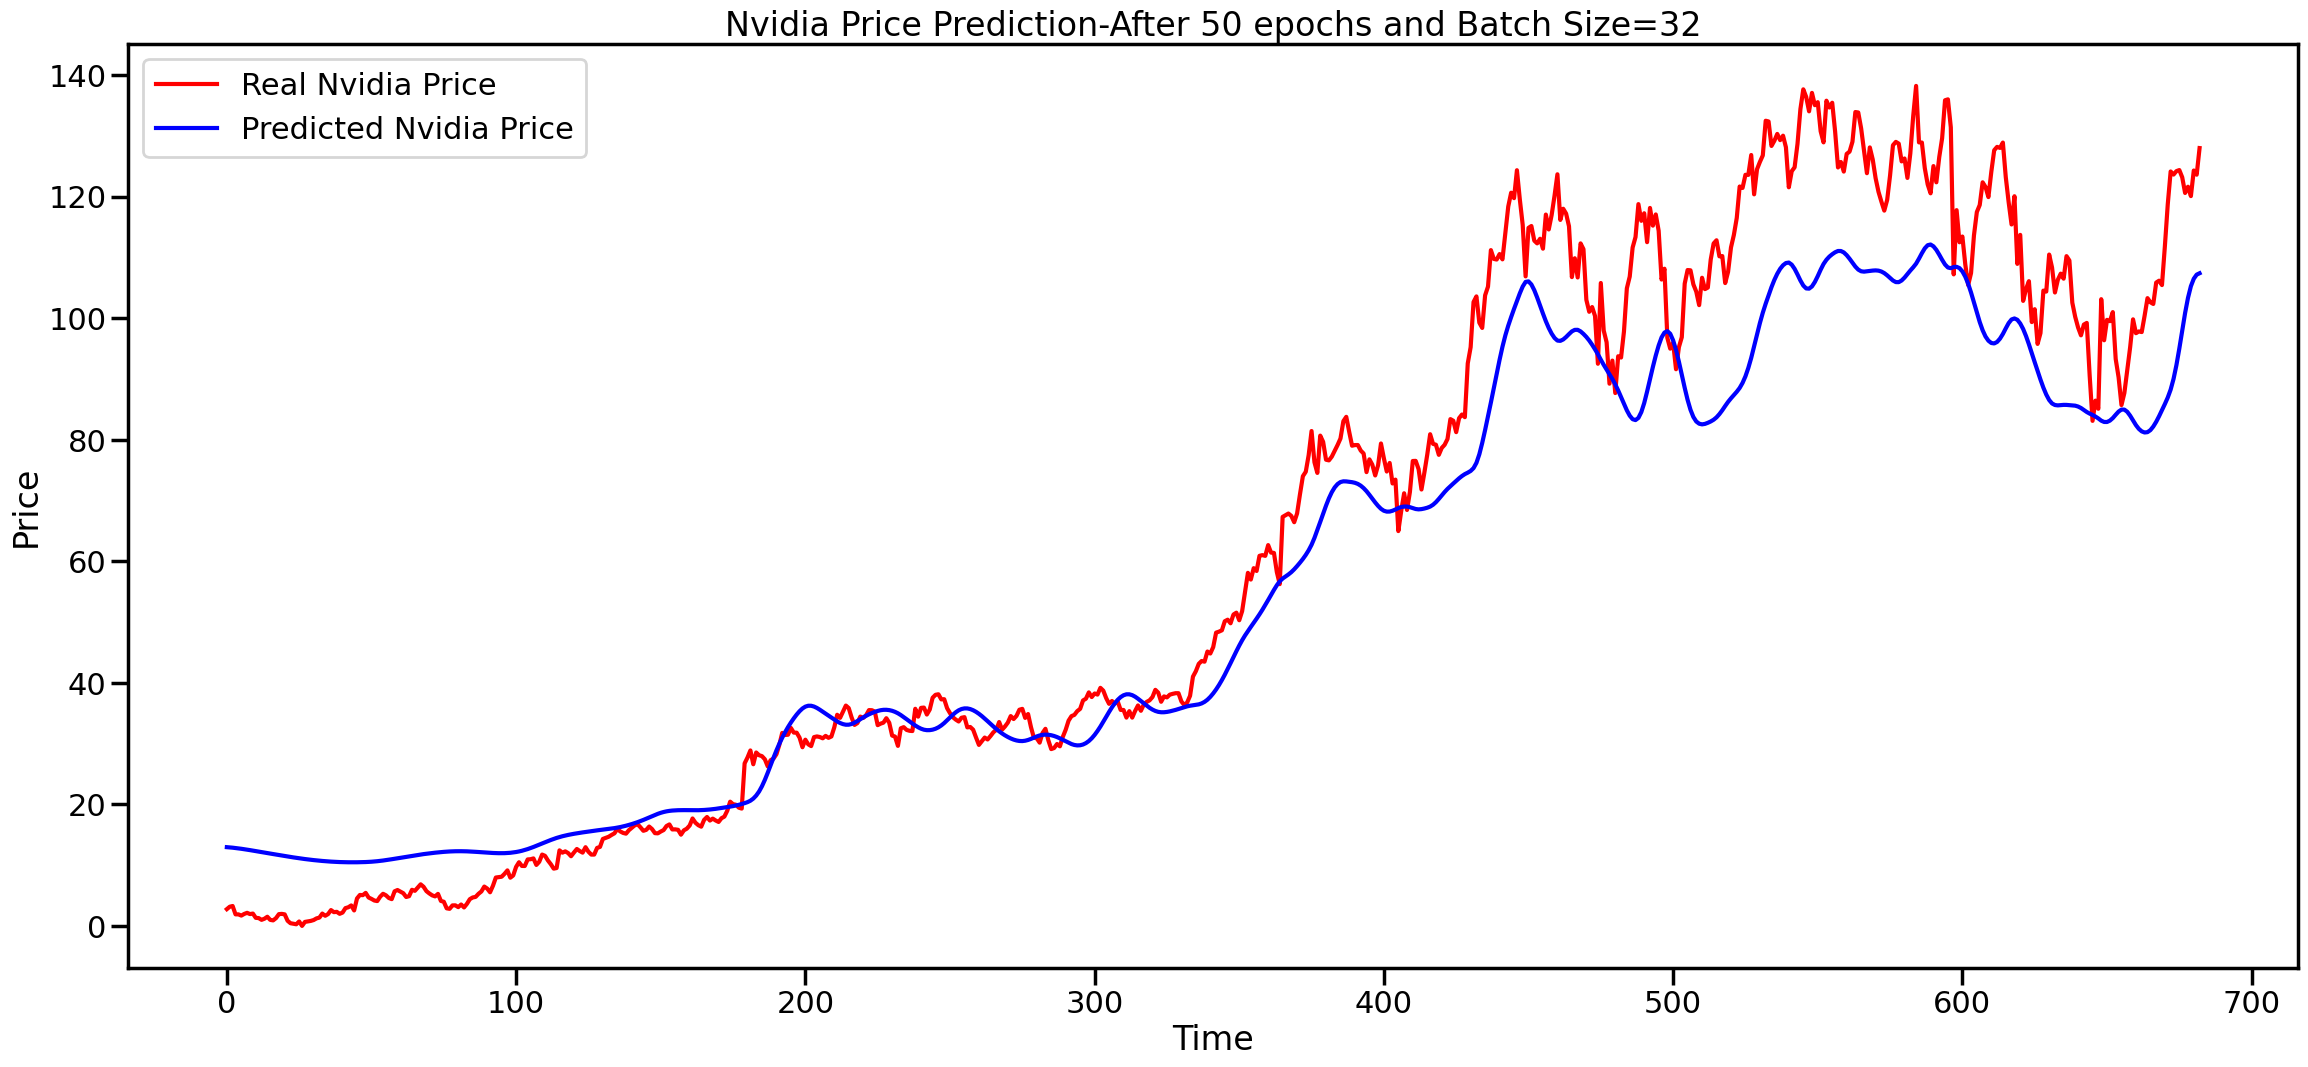

In [89]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Nvidia Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Nvidia Price')
plt.title('Nvidia Price Prediction-After 50 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

### **Model evaluation**

Calculation of mean absolute error

In [90]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
mae_percentage = (mae / np.mean(y_test)) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage))

Mean absolute error on test set: 15.94%


Calculation of R2 score

In [91]:
from sklearn.metrics import r2_score

# Actual values
actual = y_test

# Predicted values
predicted = y_pred

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 0.9157298149279235


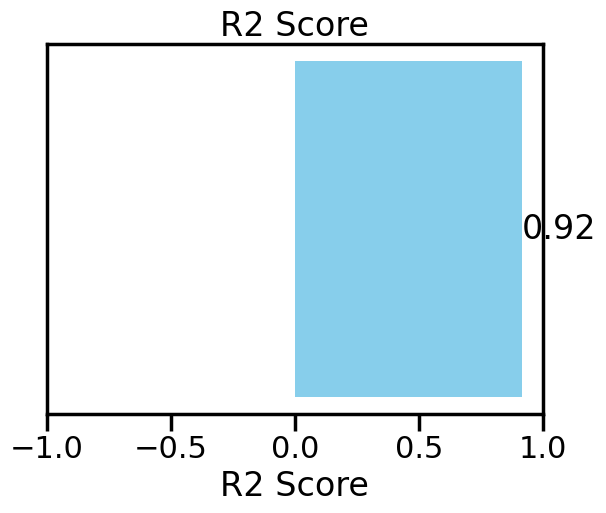

In [92]:
# Plotting the R2 score
fig, ax = plt.subplots()
ax.barh(0, r2, color='skyblue')
ax.set_xlim([-1, 1])
ax.set_yticks([])
ax.set_xlabel('R2 Score')
ax.set_title('R2 Score')

# Adding the R2 score value on the bar
ax.text(r2, 0, f'{r2:.2f}', va='center', color='black')

plt.show()

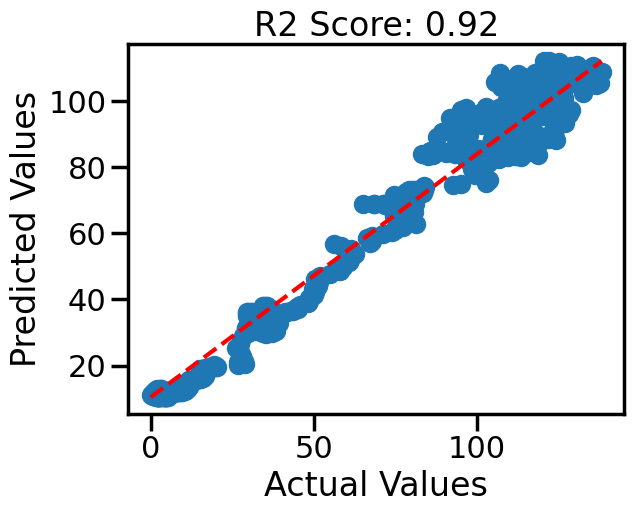

In [93]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()